In [1]:
# constants
PAYS_DATA = 'PaysData'

DATE_COL = 'Date'
COUNTRY_COL = 'Pays'
INFECTED_COL = 'Infection'
NEW_INFECTED_COL = 'InfectionNouvelles'
DEATH_COL = 'Deces'
RECOVERY_COL = 'Guerisons'
DEATH_RATE_COL = 'TauxDeces'
RECOVERY_RATE_COL = 'TauxGuerison'
INFECTED_RATE_COL = 'TauxInfection'
GROWTH_RATE_COL = 'TauxCroissance'

FRANCE = 'France'

In [2]:
# settings

URL = 'https://coronavirus.politologue.com/data/coronavirus/coronacsv.aspx?format=json'

chargement des données

In [3]:
import requests
from pymongo import MongoClient

client = None

def get_collection():
    global client
    if client is None:
        print('open new connection')
        client = MongoClient()    
    database = client.coco
    return database.per_country

def update_database():
    with requests.get(URL) as response:
        response.raise_for_status()
        data = response.json()
        
    collection = get_collection()
#     collection.delete_many({})
    data_per_country = data[PAYS_DATA]
    print(f'\t{len(data_per_country)} rows')
    for document in data_per_country:
        finder = {k:document[k] for k in document if k in [COUNTRY_COL, DATE_COL]}
        collection.find_one_and_replace(finder, document, upsert=True)
    print(f'\t{collection.count_documents({})} documents in collection')
    
update_database()

open new connection
	6436 rows
	6436 documents in collection


retraitement

In [4]:
def proccess_country_data(collection, country: str) -> None:
    country_data = collection.find({
        COUNTRY_COL: country
    })
    country_data = list(reversed(list(country_data)))
    
    [first_data, *country_data] = country_data
    perv_infected = first_data[INFECTED_COL]
    prev_new_infected = 0
    for day_data in country_data:
        new_infected = day_data[INFECTED_COL] - perv_infected
        growth_rate = 0 if prev_new_infected == 0 else new_infected / prev_new_infected
        collection.save({
            **day_data,
            NEW_INFECTED_COL: new_infected,
            GROWTH_RATE_COL: growth_rate
        })
        perv_infected = day_data[INFECTED_COL]
        prev_new_infected = new_infected

        
def get_countries(collection=None):
    if collection is None:
        collection = get_collection()
    countries = collection.distinct(COUNTRY_COL)
    return countries
        
def process_countries():
    collection = get_collection()
    countries = get_countries(collection)
    for country in countries:
        try:
            proccess_country_data(collection, country)
        except Exception as e:
            print(f'error occured with {country}: {e}')
    print('\tend processing')
            
process_countries()

/home/thomas/anaconda3/envs/coco/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: save is deprecated. Use insert_one or replace_one instead
  app.launch_new_instance()


	end processing


visualisation

In [5]:
get_countries()

['Afghanistan',
 'Afrique du Sud',
 'Albanie',
 'Algérie',
 'Allemagne',
 'Andorre',
 'Angola',
 'Antigua-et-Barbuda',
 'Arabie Saoudite',
 'Argentine',
 'Arménie',
 'Aruba',
 'Australie',
 'Autres',
 'Autriche',
 'Azerbaïdjan',
 'Bahamas',
 'Bahreïn',
 'Bangladesh',
 'Barbade',
 'Belgique',
 'Belize',
 'Bhoutan',
 'Birmanie',
 'Bolivie',
 'Bosnie-Herzégovine',
 'Botswana',
 'Brunéi Darussalam',
 'Brésil',
 'Bulgarie',
 'Burkina Faso',
 'Burundi',
 'Bélarus',
 'Bénin',
 'Cambodge',
 'Cameroun',
 'Canada',
 'Cap-vert',
 'Chili',
 'Chine',
 'Chypre',
 'Colombie',
 'Congo (Brazzaville)',
 'Corée du Sud',
 'Costa Rica',
 'Croatie',
 'Cuba',
 'Curaçao',
 "Côte d'Ivoire",
 'Danemark',
 'Djibouti',
 'Dominique',
 'El Salvador',
 'Espagne',
 'Estonie',
 'Eswatini',
 'Fidji',
 'Finlande',
 'France',
 'Fédération de Russie',
 'Gabon',
 'Gambie',
 'Ghana',
 'Gibraltar',
 'Grenade',
 'Groenland',
 'Grèce',
 'Guadeloupe',
 'Guam',
 'Guatemala',
 'Guernsey',
 'Guinée',
 'Guinée Équatoriale',
 'Guiné


	Espagne
	Taux de croissance : -0.026
	Date de la dernière données : 2020-04-04T00:00:00.000000000
	Nb de malades depuis le début : 124736
	Nb de nouveaux cas : 5537.0


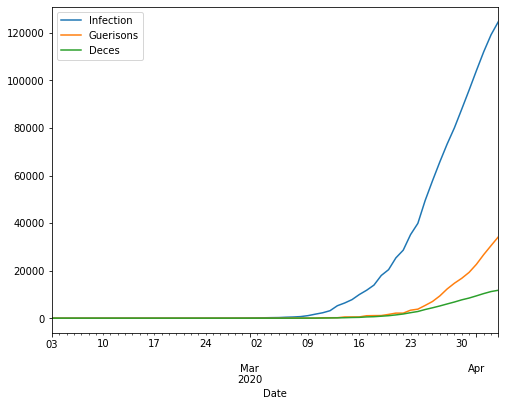

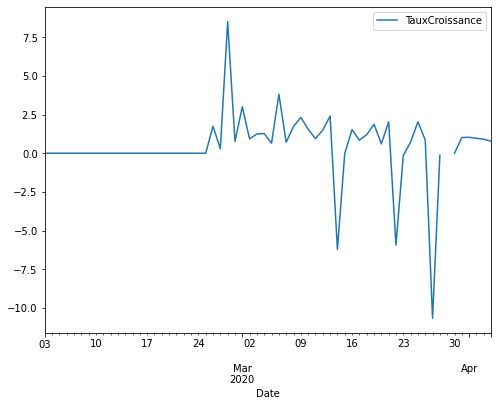

In [11]:
import numpy as np
import pandas as pd
from pymongo import MongoClient

def show_plot(df, columns):
        df.iloc[2:, :].loc[:, columns].plot(x=DATE_COL, figsize=(8, 6))

def get_dataset_by_country(country: str) -> pd.DataFrame:
    collection = get_collection()
    data = collection.find({
        COUNTRY_COL: country
    })
    dataset = pd.DataFrame(data)
    dataset[DATE_COL] = pd.to_datetime(dataset[DATE_COL])
    dataset = dataset.sort_values(by=DATE_COL)
    return dataset
        
def plot_by_country(country: str, nb_base):
    print(f'\n\t{country}')
    dataset = get_dataset_by_country(country)
    print(f'\tTaux de croissance : {dataset.loc[:, [GROWTH_RATE_COL]].tail(nb_base).mean().round(3).values[0]}')
    
    last_data = dataset.iloc[-1:, :]
    last_new_infect = last_data.loc[:, [NEW_INFECTED_COL]].values[0][0]
    last_infect = last_data.loc[:, [INFECTED_COL]].values[0][0]
    last_date = last_data.loc[:, [DATE_COL]].values[0][0]
    print(f'\tDate de la dernière données : {last_date}')
    print(f'\tNb de malades depuis le début : {last_infect}')
    print(f'\tNb de nouveaux cas : {last_new_infect}')
    show_plot(dataset, [INFECTED_COL, DATE_COL, RECOVERY_COL, DEATH_COL])
    show_plot(dataset, [DATE_COL, GROWTH_RATE_COL])
    
NB_BASE = 20
plot_by_country('Espagne', NB_BASE)

# df = get_dataset_by_country('France')
# df.tail(30)